In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import time
from datetime import datetime
from datetime import timedelta

In [64]:
files = pd.DataFrame()

for filename in os.listdir("tickerData"):
    if filename.endswith(".txt"):
        x = pd.read_csv("tickerData/"+filename)
        x.columns = [y.replace(" ", "") for y in x.columns]
        x['TICKER'] = filename[:-4]
        files = pd.concat([files,x], ignore_index=True)

In [65]:
files['DATE']  = pd.to_datetime(files['DATE'].astype('str'), format = "%Y/%m/%d")

In [66]:
files1 = files[files['TICKER'] == 'F_S'] 

In [67]:
files1

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,OI,P,R,RINFO,TICKER
0,1990-01-02,29100.0,29100.0,28750.0,28787.5,39296.0,41185.0,0,0.0,0.0,F_S
1,1990-01-03,28750.0,29112.5,28700.0,29075.0,41543.0,42002.0,0,0.0,0.0,F_S
2,1990-01-04,29150.0,29212.5,28800.0,28825.0,38533.0,42314.0,0,0.0,0.0,F_S
3,1990-01-05,28775.0,28975.0,28712.5,28850.0,31070.0,42684.0,0,0.0,0.0,F_S
4,1990-01-08,28925.0,29200.0,28900.0,29175.0,32373.0,42409.0,0,0.0,0.0,F_S
...,...,...,...,...,...,...,...,...,...,...,...
7860,2021-03-24,71087.5,71675.0,70912.5,71637.5,71361.0,314610.0,0,0.0,0.0,F_S
7861,2021-03-25,71537.5,71587.5,70525.0,70712.5,95512.0,312064.0,0,0.0,0.0,F_S
7862,2021-03-26,70700.0,70950.0,69950.0,70025.0,93202.0,307757.0,0,0.0,0.0,F_S
7863,2021-03-29,70025.0,70137.5,69150.0,69650.0,90046.0,308841.0,0,0.0,0.0,F_S


In [35]:
minmax = MinMaxScaler().fit(files1.iloc[:, 3].values.reshape((-1,1)))
close_normalize = minmax.transform(files1.iloc[:, 3].values.reshape((-1,1))).reshape((-1))

In [37]:
close_normalize.shape

(7865,)

In [38]:
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})


In [44]:
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape

/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.52455306 time: 0.012665033340454102
epoch: 20 loss: 0.5244635 time: 0.02797412872314453
epoch: 30 loss: 0.5242908 time: 0.011719942092895508
epoch: 40 loss: 0.52391714 time: 0.017735958099365234
epoch: 50 loss: 0.522862 time: 0.012213945388793945
epoch: 60 loss: 0.514655 time: 0.016499996185302734
epoch: 70 loss: 0.008348602 time: 0.021464824676513672
epoch: 80 loss: 0.006695069 time: 0.010946989059448242
epoch: 90 loss: 0.0068265735 time: 0.01121211051940918
epoch: 100 loss: 0.09208917 time: 0.011622905731201172


(7865, 32)

In [45]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

In [46]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(n_estimators=500)

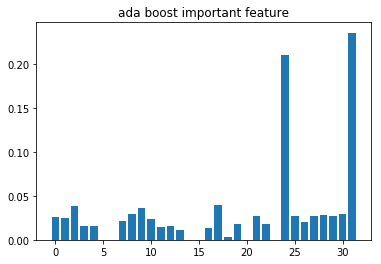

In [47]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

In [57]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

In [55]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

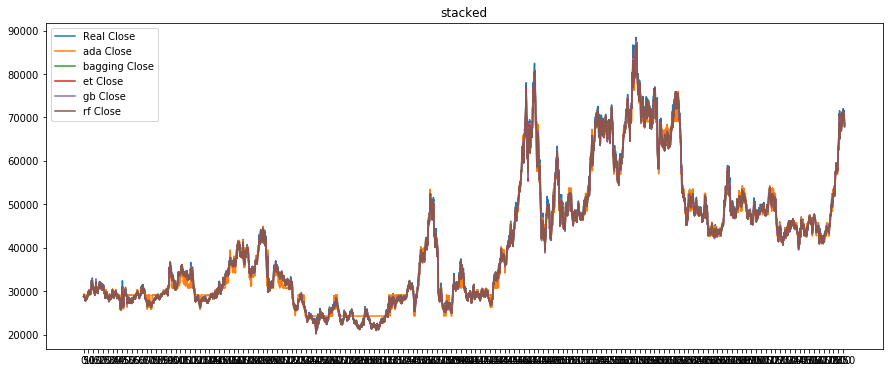

In [60]:
plt.figure(figsize = (15,6))
x_range = np.arange(files1.CLOSE.shape[0])
plt.plot(x_range, files1.CLOSE, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.legend()
plt.xticks(x_range[::50])
plt.title('stacked')
plt.show()